# Feature 5: Vectorize the Ingredient List for Clustering

In [15]:
from os import path
import random
import csv
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from sklearn.cluster import KMeans

In [16]:
# Read workbook
xls = pd.ExcelFile('Workbook.xlsx')
df1 = pd.read_excel(xls, 'merged')
ingredient_list = df1['ingredient'].tolist()

together = []
words = []

# Exmaine the Ingredients
for l in ingredient_list:
    if type(l) is str:
        #only select the alphabet and the space
        whitelist = set('abcdefghijklmnopqrstuvwxy ABCDEFGHIJKLMNOPQRSTUVWXYZ')
        word = ''.join(filter(whitelist.__contains__, l))
        if word is '':
            together.append('other')
        else:
            together.append(word.lower())
        w = word.split()
        for word in w: 
            words.append(word.lower())
    else:
        l = str(l)
        together.append('other')
            
counter=collections.Counter(words)
#print(counter)
d = dict(counter)

# A helper list to get rid of some of the excessive words
elimination = ['or','ice','cubes','water','and','fresh','','juice','for','such','as','plus','divided','slice','in','taste','de','of','optional','garnish','club','serving']

for e in elimination:
    d.pop(e,None)

## Functions that categorize similar words
- Note: these functions take about 5 min each

In [17]:
# Reference: https://stackoverflow.com/questions/35171710/how-to-group-words-whose-levenshtein-distance-is-more-than-80-percent-in-python
def groupWords(words,ratio):
    grs = [] 
    for name in words:
        for g in grs:
            if all(fuzz.token_set_ratio(name, w) >= ratio for w in g):
                g.append(name)
                break
        else:
            grs.append([name, ])
    return grs

# Another function -- replace all elements in the list with the shortest one in the grouped list
def replaceWords(oldList, groupedList):
    replaced = []
    for t in oldList:
        if t is " ":
            replaced.append('other')
        else:
            for g in groupedList:
                if t in g:
                    replaced.append(min(g, key=len))
                    break

    return replaced

In [18]:
#replace all ingredients with the above categorization
grs = groupWords(together,70)
final = replaceWords(together, grs)

## Convert the Ingredient List into One-Hot vector

In [19]:
d = {'drink_name':df1['drink_name'].tolist(),'ingredient':final,'measurement':df1['measurement'].tolist()}
#print(d)
#print(len(final))
#print(len(df1['drink_name'].tolist()))
df_feature5 = pd.DataFrame(d)
df_feature5 = df_feature5.groupby('drink_name')['ingredient'].apply(lambda x:x.tolist()).to_dict()
df_f5_final = dict()
for k in df_feature5.keys():
    ingredient_list = df_feature5[k]
    s = ''
    for l in ingredient_list:
        s = s + l+ "|"
    df_f5_final[k] = s
#print(df_f5_final)
df = pd.DataFrame(list(df_f5_final.items()),columns=['drink_name','ingredient'])
#df = pd.DataFrame.from_dict(df_f5_final)
#print(df)

vectorized = df['ingredient'].str.get_dummies('|')
onehot_df = pd.concat([df['drink_name'],vectorized],axis = 1)
display(onehot_df)

,drink_name,piece peeled cucumber,tbsp gin,activated charcoal powder,amaro such as nonino,aperol bitter orange aperitif,bags fresh cranberries,chilled,chocolate or regular stout chilled,citrus vodka,...,whole nutmeg,wide strip lemon est,wild turkey,wine,wooden or plastic skewers each threaded with a pineapple wedge and a maraschino cherry,wormwood,yearold irish whiskey such as redbreast,yoghurt,yukon jack,zima
0,North Pinckney Cocktail,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,110 in the shade,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,151 Florida Bushwacker,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,155 Belmont,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,24k nightmare,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,252,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,3 Wise Men,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,410 Gone,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,501 Blue,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,69 Special,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


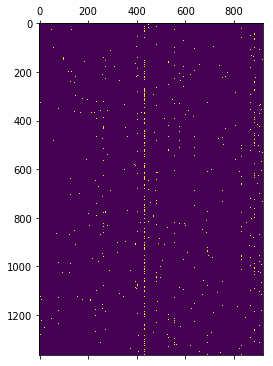

In [20]:
# a less pretty graph, sort of like heat map, you can really see some ingredients being really popular, see feature 3 for the wordcloud
arr = vectorized.values
plt.matshow(arr)

## Use query to search for all the drinks that contain a given list of ingredients

In [21]:
def findSelection(header_list, ingredient_list):
    result = []
    for i in ingredient_list:
        subresult = []
        for h in header_list:
            if i in h:
                subresult.append(h+" == 1")
        result.append(subresult)
    return result
        
#making things easier by replacing space with _
onehot_df.columns = [c.replace(' ', '_') for c in onehot_df.columns]   
header_list = list(onehot_df)[1:]

In [ ]:
# the list of ingredients
ingredient_example = ['cream','rum','pineapple']

querylist = findSelection(header_list, ingredient_example)

q_list = []

for query in querylist:
    query_str =''
    #avoid too many inputs
    count = 0
    for i in query:
        if count < 30:
            query_str = query_str+i+' | '
        count = count + 1
    query_str = query_str[:-2]
    q_list.append(query_str)

#print(q_list)
#then I use this list to find out the selection
l = []
for q in q_list:
    selection = onehot_df.query(q)
    l.append(selection.index.tolist())
    #print(selection.index.tolist())
    
common_index = list(set.intersection(*map(set, l)))

d2 = {'drink_name':df1['drink_name'].tolist(),'ingredient':final,'measurement':df1['measurement'].tolist(),'unit':df1['unit'].tolist()}

df_alldrinks = pd.DataFrame(d2)

df_alldrinks["ingredients"] = df_alldrinks["ingredient"].map(str) + ": "+df_alldrinks["measurement"].map(str) +" "+ df_alldrinks["unit"].map(str)
df_alldrinks = df_alldrinks.groupby('drink_name')['ingredients'].apply(lambda x:x.tolist()).to_dict()

#print(df_alldrinks)
drink_df = []
for k, v in df_alldrinks.items():
    drink_df.append((k,v))

pd.set_option('display.width', 5000)
display(pd.DataFrame([drink_df[i] for i in common_index],columns=["Drink","Ingredients"]))

## Use K-Means Clustering to Recommend Similar Drinks

- Running a simple K-Means clustering to determine 10 clusters based on Euclidean distances in high dimensions
- Based on the previous list of drinks, the feature also recommends 5 other drinks that are in the same cluster

In [23]:
kmeans =  KMeans(n_clusters = 10)
kmeans.fit(arr)
grouping = kmeans.labels_

# find out which groups these drinks belong to
group_indexes = [x for i,x in enumerate(grouping) if i in common_index]
#print(indexes)
drink_indexes = [i for i,x in enumerate(grouping) if x in group_indexes]
#print(drink_indexes)

#pick 5 random drinks to recommend
top_5 = random.sample(drink_indexes, len(drink_indexes))[0:5]
display(pd.DataFrame([drink_df[i] for i in top_5],columns=["Drink","Ingredients"]))

,Drink,Ingredients
0,Kurant Tea,"[absolut citron: 4.0 nan, tea: nan nan, sugar:..."
1,Afterglow,"[grenadine: 1.0 nan, aa juice: 4.0 nan, pineap..."
2,Irish Car Bomb II,"[whiskey: 0.75 fluid ounce, irish cream: 0.75 ..."
3,Rum Old-fashioned,"[light rum: 5.5 oz, proof rum: 1.0 nan, powder..."
4,Fighting Irish,[yearold irish whiskey such as redbreast: 0.75...
